In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

In [ ]:
# Snippet to load an image via imageio and normalize pixel values by 255.0
def load_image1(path):
    import imageio
    img = imageio.imread(path)
    img = torch.tensor(img).float() / 255.
    return img

# Snippet to load an image via torchvision and normalize pixel values by 255.0
def load_image2(path):
    img = torchvision.io.read_image(path)
    # [C, H, W] -> [H, W, C]
    img = img.permute(1,2,0)[..., :3]/255.
    return img

# Snippet to compute PSNR
def psnr(pred, target):
    mse = ((pred - target)**2).mean()
    return -10 * torch.log10(mse)

# Function to display ground truth and predicted image
def display_image(img, pred_img):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title('Ground Truth')
    ax[0].axis('off')
    ax[1].imshow(pred_img)
    ax[1].set_title('Predicted')
    ax[1].axis('off')
    plt.show()

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Write MLP definition
        self.layer1 = nn.Linear(2, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, 3)

    def forward(self, x):
        # write forward function, return output
        x = self.layer1(x)
        x = torch.nn.functional.relu(x, inplace=False)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x, inplace=False)
        x = self.layer3(x)
        x = torch.nn.functional.relu(x, inplace=False)
        x = self.layer4(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
# Try to load the image - assuming it exists in the current directory
try:
    img = load_image2('image.jpg')
except Exception as e:
    print(f"Error loading image: {e}")
    # Create a dummy image for demonstration
    img = torch.zeros(512, 512, 3)
    # Add some color patterns for demonstration
    for i in range(512):
        for j in range(512):
            img[i, j, 0] = i / 512  # R channel
            img[i, j, 1] = j / 512  # G channel
            img[i, j, 2] = (i+j) / (2*512)  # B channel

h, w = img.shape[0]//2, img.shape[1]//2
img = img[h-256:h+256, w-256:w+256]

In [ ]:
# Prepare test data
x_test = []
y_test = []
for i in range(0, 512):
    for j in range(0, 512):
        x_test.append([i/512, j/512])
        y_test.append([img[i, j, 0], img[i, j, 1], img[i, j, 2]])
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

print(x_test.size())
print(y_test.size())

# Prepare training data
x_train = []
y_train = []
for i in range(0, 512, 2):
    for j in range(0, 512, 2):
        x_train.append([i/512, j/512])
        y_train.append([img[i, j, 0], img[i, j, 1], img[i, j, 2]])
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

print(x_train.size())
print(y_train.size())

torch.Size([262144, 2])
torch.Size([262144, 3])
torch.Size([65536, 2])
torch.Size([65536, 3])


In [ ]:
# Initialize model and optimizer
model = NeuralNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
# Training for 50 iterations
best_score = 0
best_epoch = 0
best_pred_img = None
train_psnrs = []
test_psnrs = []
criterion = torch.nn.MSELoss()

for epoch in range(50):
    # Training step
    opt.zero_grad()
    pred_val = model(x_train)
    L = criterion(pred_val, y_train)
    L.backward()  # This should work now
    opt.step()

    # Evaluation
    with torch.no_grad():
        train_psnr_val = psnr(pred_val, y_train)
        train_psnrs.append(train_psnr_val.item())

        test_pred = model(x_test)
        test_psnr_val = psnr(test_pred, y_test)
        test_psnrs.append(test_psnr_val.item())

        # Save best model and prediction
        if test_psnr_val > best_score:
            best_score = test_psnr_val
            best_epoch = epoch

            # Reshape prediction for visualization
            pred_img = test_pred.reshape(512, 512, 3).cpu().detach().numpy()
            best_pred_img = pred_img

    print(f"Epoch:{epoch+1} Loss:{L.item():.6f} Train PSNR:{train_psnr_val:.2f} Test PSNR:{test_psnr_val:.2f}")

Epoch:1 Loss:0.064762 Train PSNR:11.89 Test PSNR:11.91
Epoch:2 Loss:0.064334 Train PSNR:11.92 Test PSNR:11.94
Epoch:3 Loss:0.063922 Train PSNR:11.94 Test PSNR:11.97
Epoch:4 Loss:0.063528 Train PSNR:11.97 Test PSNR:11.99
Epoch:5 Loss:0.063153 Train PSNR:12.00 Test PSNR:12.02
Epoch:6 Loss:0.062798 Train PSNR:12.02 Test PSNR:12.04
Epoch:7 Loss:0.062465 Train PSNR:12.04 Test PSNR:12.06
Epoch:8 Loss:0.062148 Train PSNR:12.07 Test PSNR:12.08
Epoch:9 Loss:0.061846 Train PSNR:12.09 Test PSNR:12.10
Epoch:10 Loss:0.061559 Train PSNR:12.11 Test PSNR:12.12
Epoch:11 Loss:0.061289 Train PSNR:12.13 Test PSNR:12.14
Epoch:12 Loss:0.061036 Train PSNR:12.14 Test PSNR:12.16
Epoch:13 Loss:0.060797 Train PSNR:12.16 Test PSNR:12.17
Epoch:14 Loss:0.060575 Train PSNR:12.18 Test PSNR:12.19
Epoch:15 Loss:0.060370 Train PSNR:12.19 Test PSNR:12.20
Epoch:16 Loss:0.060177 Train PSNR:12.21 Test PSNR:12.22
Epoch:17 Loss:0.059997 Train PSNR:12.22 Test PSNR:12.23
Epoch:18 Loss:0.059829 Train PSNR:12.23 Test PSNR:12.24
E


Best PSNR: 12.51 at epoch 50


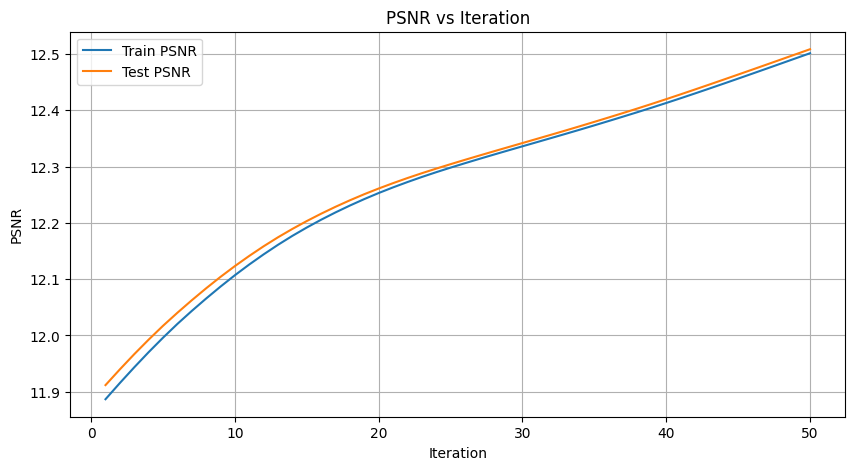

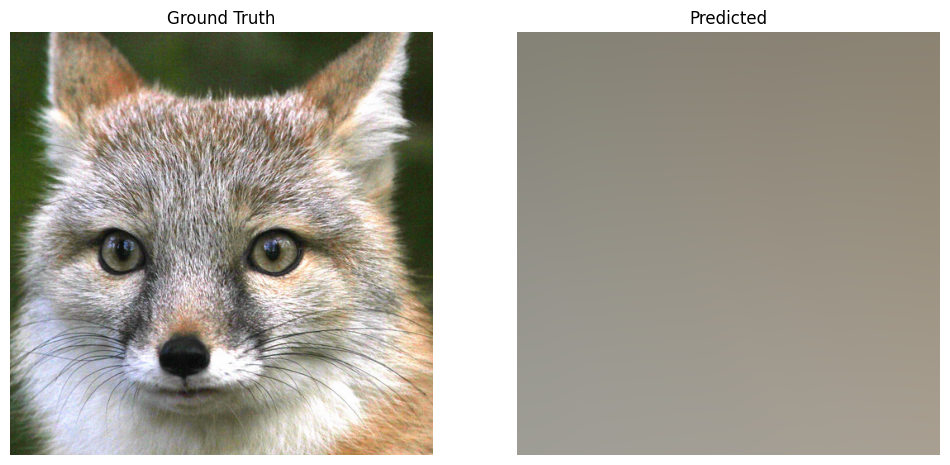

In [ ]:
print(f"\nBest PSNR: {best_score:.2f} at epoch {best_epoch+1}")

# Plot PSNR vs iteration curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), train_psnrs, label='Train PSNR')
plt.plot(range(1, 51), test_psnrs, label='Test PSNR')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Display best output image vs original image
original_img = img.cpu().detach().numpy()
display_image(original_img, best_pred_img)